In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy import special

In [114]:
data_test = np.array(pd.read_csv('./emnist_test.csv'), dtype='float64')
data_train = np.array(pd.read_csv('./emnist_train.csv'), dtype='float64')

In [155]:
def vectorized_answer(i):
    v = np.zeros( (27, 1) )
    v[i] = 1
    return v

data_train_list = [(np.reshape(x[1:] / 255.0, (784, 1)), vectorized_answer(int(x[0]))) for x in data_train]
data_test_list = [(np.reshape(x[1:] / 255.0, (784, 1)), int(x[0]))for x in data_test]

In [156]:
for i in  data_test_list[0][0] / 255.0 :
	print(i, end=' ')

[0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [6.1514802e-05] [0.00032295] [0.00030757] [1.53787005e-05] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [1.53787005e-05] [0.0005075] [0.00176855] [0.00264514] [0.00235294] [0.00030757] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.] [0.00012303] [0.00195309] [0.00339869] [0.00389081] [0.00390619] [0.00330642] [0.00056901] [0.] [0.] [0.] [0.] [0.]

A


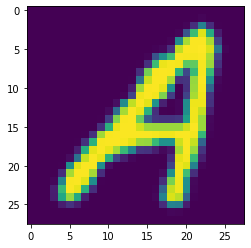

In [157]:
x, y = data_test_list[0]
plt.imshow(np.reshape(x, (28, 28)).T)
print(chr(y + 64))

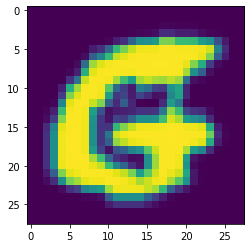

In [158]:
sample = data_train_list[0]
plt.imshow(np.reshape(sample[0], (28, 28)).T)

In [159]:
# def sigmoid(x):
#     return 1.0 / (1.0 + np.exp(-x))

"""
Аналог сигмоиды.
"""
def sigmoid(x):
    return special.expit(x)

def sigmoid_prime(x):
    """
    Производная сигмоидной функции.
    """
    a = sigmoid(x)
    return a * (1 - a)

In [160]:
class QuadraticCost:
    def fn(a, y):
        return 0.5 * np.linalg.norm(a - y)**2
    def delta(x, a, y):
        return (a - y) * sigmoid_prime(x)

In [167]:
class Network:
    def __init__(self, layer_sizes):
        self.layer_count = len(layer_sizes)
        self.layer_sizes = layer_sizes
        self.cost_function = QuadraticCost
        self.biases = [np.random.randn(y, 1) for y in self.layer_sizes[1:]]
        self.weights = [np.random.randn(y, x) / np.sqrt(x) for x, y in zip(self.layer_sizes[:-1], self.layer_sizes[1:])]
    
    def SGD(self, data_train_list, data_test_list, epochs, n_batch, lr, reg):
        n_train = len(data_train_list)
        n_test = len(data_test_list)
        for e in range(epochs):
            """
            В одной epoch можно использовать только 80% всех данных.
            """
            np.random.shuffle(data_train_list)
            r = range(0, int(n_train * 0.8), n_batch)
            batch_list = [ data_train_list[k:k+n_batch] for k in r ]
            for batch in batch_list:
                self.update_batch(batch, lr, reg, n_train, n_batch)
            eval = self.evaluate(data_test_list)
            print(f"epoch_{e}: {n_test} / {eval} = {eval / n_test}")

    def update_batch(self, batch, lr, reg, n_train, n_batch):
        """
        Будем возвращать градиент функции затрат в виде 'grad_b' и 'grad_w'.
        """
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in batch:
            delta_grad_b, delta_grad_w = self.forward_backward_propagation(x, y)
            grad_b = [b + dgb for b, dgb in zip(grad_b, delta_grad_b)]
            grad_w = [w + dgw for w, dgw in zip(grad_w, delta_grad_w)]
        self.weights = [(1 - lr * (reg / n_train)) * w - (lr / n_batch) * gw for w, gw in zip(self.weights, grad_w)]
        self.biases = [b - (lr / n_batch) * gb for b, gb in zip(self.biases, grad_b)]

    def forward_backward_propagation(self, x, y):
        """
        Шагаем вперед.
        """
        grad_b = [np.zeros(b.shape) for b in self.biases]
        grad_w = [np.zeros(w.shape) for w in self.weights]
        activation = x
        activations = [x]
        z_array = []
        for b, w in zip(self.biases, self.weights):
            z = np.dot(w, activation) + b
            z_array.append(z)
            activation = sigmoid(z)
            activations.append(activation)

        """
        Шагаем назад.
        """
        delta = self.cost_function.delta(z_array[-1], activations[-1], y)
        grad_b[-1] = delta
        grad_w[-1] = np.dot(delta, activations[-2].T)
        
        for l in range(2, self.layer_count):
            sp = sigmoid_prime(z_array[-l])
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            grad_b[-l] = delta
            grad_w[-l] = np.dot(delta, activations[-l - 1].T)
        return (grad_b, grad_w)
    
    def feed(self, v):
        for b, w in zip(self.biases, self.weights):
            v = sigmoid(np.dot(w, v) + b)
        return v

    def evaluate(self, data_test_list):
        results = [(np.argmax(self.feed(x)), y) for (x, y) in data_test_list]
        return sum(int(x == y) for (x, y) in results)
        

epochs = 10
batch_size = 10
learning_rate = 3.4
regularization = 3.7
net = Network([784,40,40,27])
net.SGD(data_train_list, data_test_list, epochs, batch_size, learning_rate, regularization)

epoch_0: 14799 / 10409 = 0.7033583350226367


KeyboardInterrupt: 